# Project Notebook
##### Created by Dario Sandrucci 48436

bla bla bla

### 0. Import Packages

In [1]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

##### 1.1 Loading Data

Let import return data from S&P 500 stocks over the period of approximately the last 10 years.

In [2]:
tickers = getTickers()
end = dt.now()
start = dt.fromisoformat('2017-11-17')
df = getData(start, end, tickers, downloaded = True)

Data was loaded sucessfully!


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample.

In [ ]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Log Returns of S&P500 Stocks for Training Period')

A chart to show the cummulative returns of the SPY index over the data period.

In [ ]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

We will split the set into train and test set.

In [3]:
train_set, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.8, 0.2])

Now lets derive the empirical correlation matrix of our return data.

In [4]:
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = train_set.columns, columns = train_set.columns )

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr0)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

### 2. Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [5]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr1)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr1, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

Next lets detone the correlation matrix.

In [6]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)

In [ ]:
# Create a heatmap of the correlation matrix
sns.heatmap(corr2)
plt.title('Correlation Matrix')

# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(8,8)).fig.suptitle('Stocks Clustered Based on Correlation Distances', fontsize=14)

## 3. Distance Metrics

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly.

In [7]:
from sklearn.metrics import pairwise_distances

In [8]:
min_matrix = np.array(pairwise_distances(corr2, metric = "minkowski"))

## 3. Portfolio Construction

#### 3.1 Clustering

##### 3.1.1 Finding the number of clusters

Our first method is the Elbow method

In [ ]:
nr_clusters_sse = sse(min_matrix)

Now lets try the Silhouette method

In [ ]:
nr_clusters_sil = sil_score(min_matrix)

Our last method is the Davies-Boulding Score

In [ ]:
nr_clusters_db = db_score(min_matrix)

We will use the median number of clusters for for Kmeans.

##### 3.1.2 Running the clustering algorithm

In [ ]:
w = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)

## 4. Perfromance evaluation

#### 4.1. Benchmarking

##### 4.1.1 Clustering vs general portfolios

We will compare our clustering portfolio with a few other common portfolio types, the mean-variance optimized (MVP), risk-parity (RPP), and equal-weighted portfolio (EWP), as well as the S&P index itself (SPY).

First let calculated the portfolio weights:

In [13]:
#Clustering
w_NCOMO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)
#EW
w_EW = np.ones(len(train_set.columns))
w_EW /= [len(train_set.columns)]*len(train_set.columns)
#MVO
w_MVO = optPortMVO(train_set)
#RPP
w_RPP = optPortRPP(train_set)

Nested clustering algorithm calculating ...
Calculations completed sucessful!


KeyboardInterrupt: 

Not lets build the portfolios:

In [14]:
#building the single portfolios
port_NCOMO = Portfolio("NCO Minkowski Omega", test_set, w_NCOMO)
port_EWP = Portfolio("Equal Weighted", test_set, w_EW)
port_MVO = Portfolio("Mean Variance", test_set, w_MVO)
port_RPP = Portfolio("Risk Parity", test_set, w_RPP)
#comparing the portfolios
BM1 = PortfolioBenchmarking([port_NCOMO, port_EWP, port_MVO, port_RPP])

NameError: name 'w_MVO' is not defined

We are ready to perform some comparisons:

In [15]:
BM1.plot_performance()

NameError: name 'BM1' is not defined

##### 4.1.2 Cluster algorithm configurations

We will now compare different configurations of the NCO to see the impact of different inputs. First lets calculate again the different weights:

In [ ]:
# Investing just in a portfolio mean-variance optimized with the denoised and detoned correlation matrix
cov0 = corr2cov(corr2)
w_cov_only = optPortMVO(train_set, cov = cov0, cov_in = True)

# NCO with normal correlation matrix and omega opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_DO = optPort_nco(train_set, dist_matrix, 3, 0.5, 50, 5)

# NCO with minkowski distance matrix and sharpe opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_MS = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5)

# NCO with normal correlation matrix and sharpe opimization
dist_matrix = pairwise_distances(corr2)
w_NCO_DS = optPort_nco(train_set, dist_matrix, 3, 0.5, 50, 5)

Let's build the portfolios

In [ ]:
# Correlation matrix only
port_COV = Portfolio("Denoised and Detoned", test_set, w_cov_only)
# Minkowski Omega
port_NCOMO = Portfolio("NCO Minkowski Omega", test_set, w_NCOMO)
# Minkowski Sharpe
port_NCOMS = Portfolio("NCO Minkowski Sharpe", test_set, w_NCO_MS)
# Correlation Omega
port_NCODO = Portfolio("NCO Correlation Omega", test_set, w_NCO_DO)
# Correlation Sharpe
port_NCODS = Portfolio("NCO Correlation Sharpe", test_set, w_NCO_DS)

# Combined
BM2 = PortfolioBenchmarking([port_COV, port_NCOMO, port_NCOMS, port_NCODO, port_NCODS])

Performance Comparison

In [ ]:
BM2.plot_performance()

##### 4.1.3 Long-Only vs. Long-Short

Lets get the portfolio weights

In [ ]:
# Long Only
w_NCOMO_LO = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, constraint = "Long-Only")
#Long Short
w_NCOMO_LS = optPort_nco(train_set, min_matrix, 3, 0.5, 50, 5, constraint = "Long-Short")

Lets build the portfolio

In [ ]:
# Correlation matrix only
port_NCOMO_LO = Portfolio("NCO Long-Only", test_set, w_NCOMO_LO)
# Minkowski Omega
port_NCOMO_LS = Portfolio("NCO Long-Short", test_set, w_NCOMO_LS)

# Combined
BM3 = PortfolioBenchmarking([port_NCOMO_LS, port_NCOMO_LO])

Let compare

In [ ]:
BM3.plot_performance()

### 4.2. Robustness Analysis

##### 4.2.1 Time dimensioning

Let discover the effect of different train-test split layouts on the model performance. The are 2 parateter that we will explore. The ratio of train and test split and the overall sample size.

Train Test Ration

##### 4.2.2 Rebalacing

Let discover the effect of rebalacing on the porfolio performance.

In [9]:
investment_start = test_set.index[0]
investment_start
# potfolio with rebalacing
ret_RB = optPort_nco_RB(df, investment_start, 50)

Calculations for rebalanced portfolio in progress...
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clustering algorithm calculating ...
Calculations completed sucessful!
Nested clus

In [24]:
port_NCOMO_RB = Portfolio_Ret("NCO Monthly Rebalanced", ret_RB.iloc[:len(ret_RB)-1])

In [25]:
bm4 = PortfolioBenchmarking([port_NCOMO_RB, port_NCOMO])

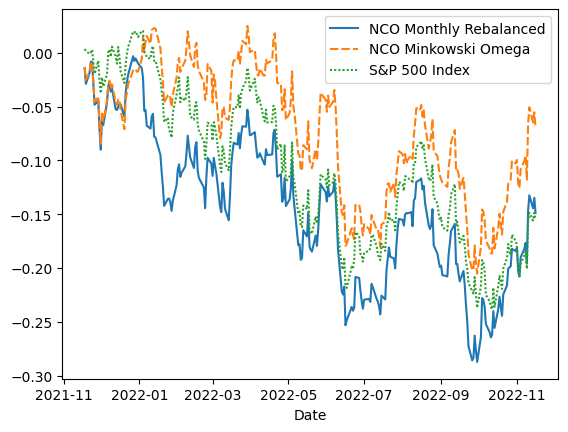

In [26]:
bm4.plot_performance()

##### 4.2.3 Application in a different market environment

For compareable data we will use the components of the Jakarta Composite Index. 

In [280]:
df_tyo = pd.read_csv("data/nikkei225comps.csv")
df_tyo = df_tyo.set_index("Date").pct_change().iloc[1:]
df_tyo.index = pd.to_datetime(df_tyo.index)

In [302]:
train_set_tyo, test_set_tyo = testTrainSplit(df_tyo, validation_set = False, w_tt = [0.8, 0.2])

corr0_tyo = train_set_tyo.corr()#.fillna(0)

eVal0_tyo, eVec0_tyo, eVal1_tyo, eVec1_tyo, corr1_tyo, var0_tyo = denoiseMatrix(corr0_tyo)
corr2_tyo = detoneMatrix(corr1_tyo, eVal1_tyo, eVec1_tyo)

min_matrix_tyo = np.array(pairwise_distances(corr2_tyo, metric = "minkowski"))

3

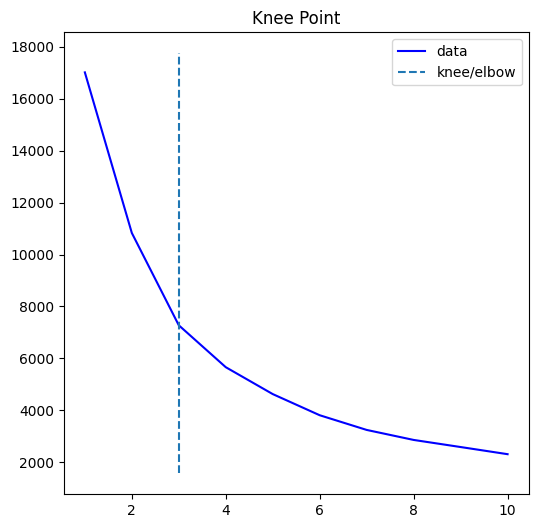

In [303]:
sse(min_matrix_tyo)

In [304]:
w_tyo = optPort_nco(train_set_tyo, min_matrix_tyo, 3, 0.5, 500, 5)

Nested clustering algorithm calculating ...
Calculations completed sucessful!


In [305]:
# Jakarta Composite NCO Optimized Port
tyo_port = Portfolio("NCO Nikkei225 Components", test_set_tyo[1:], w_tyo)
# Jakarta Composite Index
nikkei225_ret = pdr.get_data_yahoo(["^N225"], test_set_tyo.index[0], end)["Close"].pct_change()[1:len(test_set_tyo)]
nikkei225_ret = pd.Series(nikkei225_ret.values.reshape(-1), index = nikkei225_ret.index)
nikkei225_port = Portfolio_Ret("Nikkei225 Index", nikkei225_ret)

In [306]:
BM5 = PortfolioBenchmarking([tyo_port,nikkei225_port])

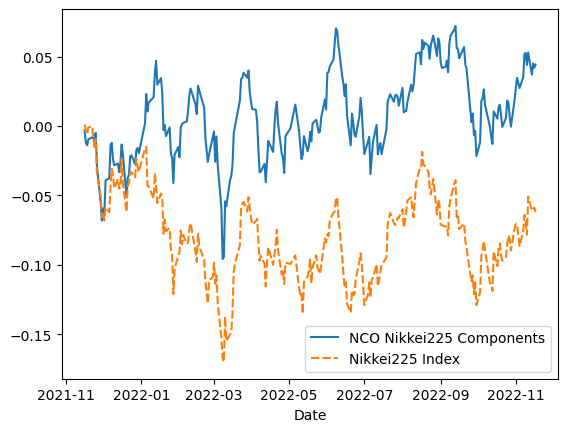

In [307]:
BM5.plot_performance(False)